The ***SMSSpamCollection*** dataset, which contains over 5000 SMS phone messages, was used.

The file is a tab-separated-values(tsv) file with four columns:
> **label** - every message is labeled as either ***ham*** or ***spam***<br>
> **message** - the message itself<br>
> **length** - the number of characters in each message<br>
> **punct** - the number of punctuation characters in each message

## Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import seaborn as sns
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import string # collection of alphabets, words or other characters
import re # regular expression
import gensim # representing documents as semantic vectors
from nltk.corpus import stopwords
from nltk import pos_tag # Part-of-Speech (POS) tagging
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from sklearn import metrics
from wordcloud import WordCloud # to visualize text
from sklearn.feature_extraction.text import TfidfVectorizer # converts a collection of raw documents into a matrix
from PIL import Image # import image
from matplotlib.cm import ScalarMappable # for colormap 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize # splits sentence into words 
from nltk.corpus import wordnet # large lexical database of English words

import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
df = pd.read_csv('../TextFiles/smsspamcollection.tsv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [3]:
len(df)

5572

## Check for missing values

In [4]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

## Ham / Spam Messages wordCloud

In [5]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:

def clean_text(text):
    # remove \t
    text = text.replace('\t', '')
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stop_words]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = ' '.join(text)
    return(text)

In [7]:
df['New_Message'] = df['message'].apply(lambda x: clean_text(x))
df.head()

,label,message,length,punct,New_Message
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,go jurong point crazy available bugis great wo...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,49,6,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,nah think go usf life around though


In [8]:
df['spamham'] = df['label'].apply(lambda x: 0 if x == 'ham' else 1)

In [9]:
train_ham = df[ df['spamham'] == 0]
train_ham = train_ham['New_Message']

In [10]:
def wordCloud_generator(data, color, color_map):
    
    wave_mask = np.array(Image.open('cloud.png'))
    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                          mask = wave_mask
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

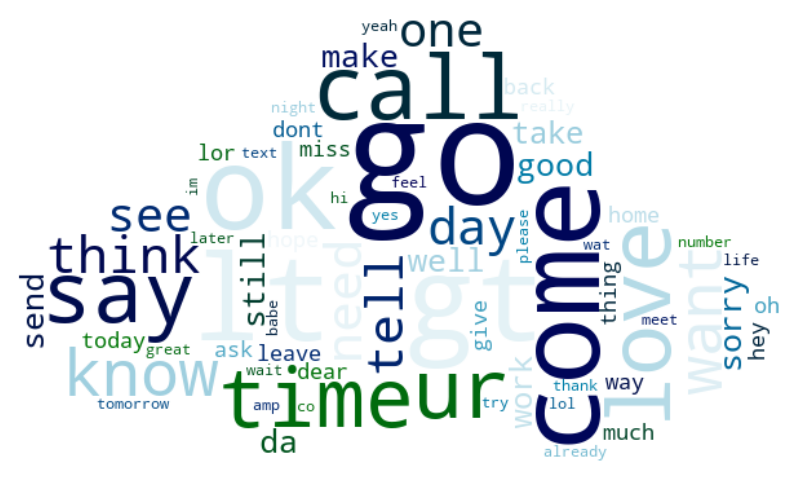

In [11]:
# WordCloud for Ham Message

wordCloud_generator(train_ham, 'white', 'ocean')

In [12]:
train_spam = df[ df['spamham'] == 1]
train_spam = train_spam['New_Message']

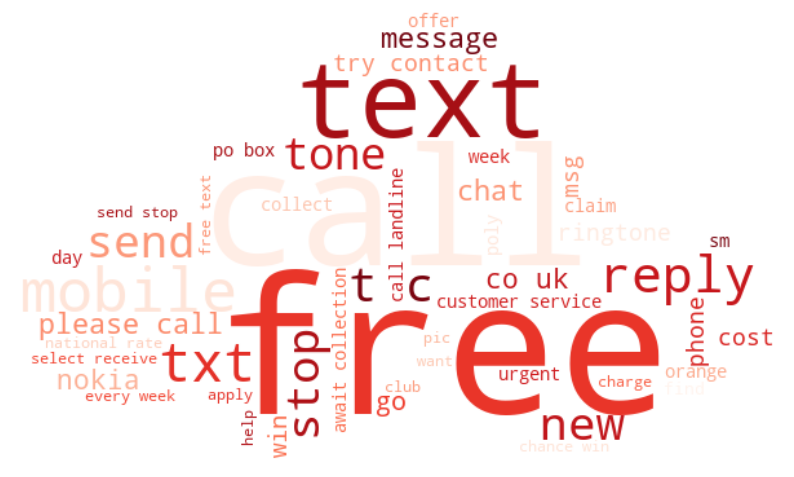

In [13]:
# Wordcloud for Spam Message

wordCloud_generator(train_spam, 'white', 'Reds')

In [14]:
# drop the Clean_Message Column, because we won't use it
df = df.drop(['New_Message'], axis = 1)
df.head(15)

,label,message,length,punct,spamham
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,0
1,ham,Ok lar... Joking wif u oni...,29,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,1
3,ham,U dun say so early hor... U c already then say...,49,6,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,8,1
6,ham,Even my brother is not like to speak with me. ...,77,2,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,6,0
8,spam,WINNER!! As a valued network customer you have...,157,6,1
9,spam,Had your mobile 11 months or more? U R entitle...,154,2,1


## Take a quick look at the ham and spam label column

In [15]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [16]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

## Visualize the data

Text(0.5, 0, 'Message Length')

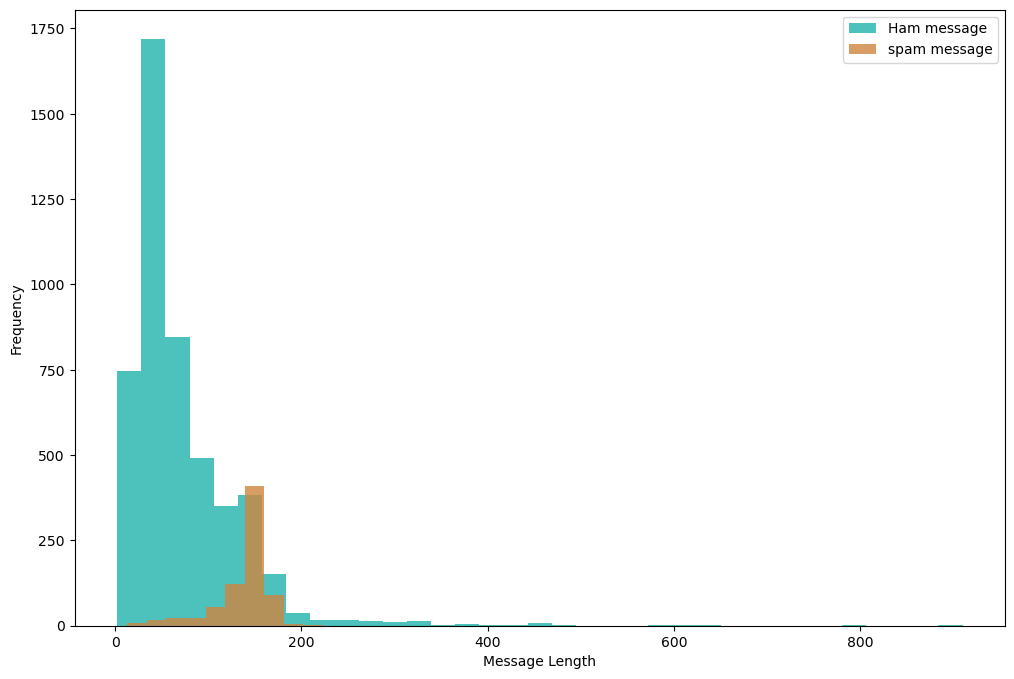

In [17]:
plt.figure(figsize=(12,8))
df[df.label=='ham'].length.plot(bins=35, kind='hist',color='#20b2aa', 
                                      label='Ham message',alpha=0.8)
df[df.label=='spam'].length.plot(kind='hist',color='#cd853f',
                                        label='spam message', alpha=0.8)
plt.legend()
plt.xlabel("Message Length")

In [18]:
df[df.label=='ham'].describe()

,length,punct,spamham
count,4825.000000,4825.000000,4825.0
mean,71.482487,3.939896,0.0
std,58.440652,4.734768,0.0
min,2.000000,0.000000,0.0
25%,33.000000,1.000000,0.0
50%,52.000000,3.000000,0.0
75%,93.000000,5.000000,0.0
max,910.000000,133.000000,0.0


In [19]:
df[df.label=='spam'].describe()

,length,punct,spamham
count,747.000000,747.000000,747.0
mean,138.670683,5.712182,1.0
std,28.873603,3.460834,0.0
min,13.000000,0.000000,1.0
25%,133.000000,3.000000,1.0
50%,149.000000,5.000000,1.0
75%,157.000000,8.000000,1.0
max,223.000000,26.000000,1.0


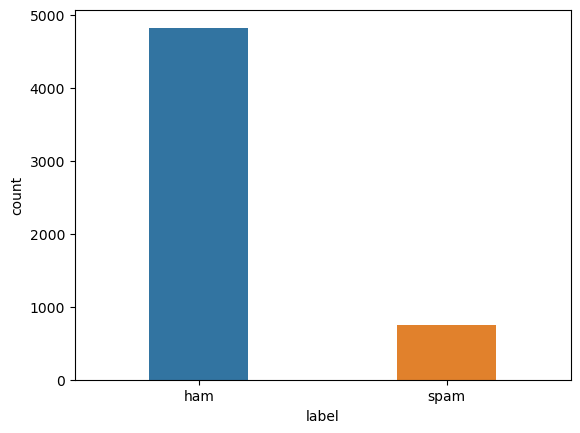

In [20]:
sns.countplot(x=df["label"],width=0.4);

## Split the data into train & test sets

In [21]:
X = df['message'] 
y = df['label']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (3733,)
Testing Data Shape:  (1839,)


## Build pipelines to vectorize the data, then train and fit a model

In [23]:
# Logistic Regression:
text_clf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lr_model', LogisticRegression(solver='lbfgs')),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lsvc', LinearSVC()),
])


### Feed the training data through the first pipeline

In [24]:
text_clf_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr_model', LogisticRegression())])

### Run predictions and analyze the results (Logistic Regression)

In [25]:
# Form a prediction set
predictions = text_clf_lr.predict(X_test)

In [26]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[1591    2]
 [  50  196]]


In [27]:
# You can make the confusion matrix less confusing by adding labels:
df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['ham','spam'], columns=['ham','spam'])
df

,ham,spam
ham,1591,2
spam,50,196


In [28]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1593
        spam       0.99      0.80      0.88       246

    accuracy                           0.97      1839
   macro avg       0.98      0.90      0.93      1839
weighted avg       0.97      0.97      0.97      1839



In [29]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9717237629146275


### Feed the training data through the second pipeline

In [30]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lsvc', LinearSVC())])

### Run predictions and analyze the results (Linear SVC)

In [31]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [32]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[1586    7]
 [  12  234]]


In [33]:
# You can make the confusion matrix less confusing by adding labels:
df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['ham','spam'], columns=['ham','spam'])
df

,ham,spam
ham,1586,7
spam,12,234


In [34]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1593
        spam       0.97      0.95      0.96       246

    accuracy                           0.99      1839
   macro avg       0.98      0.97      0.98      1839
weighted avg       0.99      0.99      0.99      1839



In [35]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.989668297988037


## Let's test

In [36]:
text_clf_lsvc.predict(["hi,how are you doing today?"])

array(['ham'], dtype=object)

In [37]:
text_clf_lsvc.predict(["Congratulations!You've won a $1000 Amazon gift card."])

array(['spam'], dtype=object)